# Model Output Data Visualization

### Read Me

This notebook visualizes model outputs for both supervised neural methods and unsupervised methods from the rPPG Toolbox. To use this notebook follow the following steps:

**For supervised neural methods:**
* STEP 1: Specify the `TEST.OUTPUT_SAVE_DIR` field in the `.yaml` config file of a neural method experiment.
* STEP 2: Run the neural method experiment. A `.pickle` file containing the test-data predictions and labels will be created in `TEST.OUTPUT_SAVE_DIR`.

**For unsupervised methods:**
* STEP 1: Specify the `UNSUPERVISED.OUTPUT_SAVE_DIR` field in the `.yaml` config file of an unsupervised method experiment.
* STEP 2: Run the unsupervised method experiment. A `.pickle` file containing the predictions and labels will be created in `UNSUPERVISED.OUTPUT_SAVE_DIR`.

**For both methods:**
* STEP 3: Add the path to the `pickle` file in the `TODO: Variable to Set` section as `data_out_path`.
* STEP 4: Add values for `trial_idx` (a value between 0 and the `Num Trials` print in the previous cell), `chunk_size` (number of samples to plot out), `chunk_num` (the chunk of size `chunk_size` in the signal). We suggest using the defaults at first.
* STEP 5: Run all cells. The predicted output, plotted against the ground truth ppg waveform, will be plotted in the final cell

### Imports

In [15]:
# !pip install natsort
!pip install scipy
# !pip install natsort
# !pip install ipywidgets

import cv2
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
import re

import torch

import numpy as np
# import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

### Helper Functions

In [16]:
# HELPER FUNCTIONS

def _reform_data_from_dict(data, flatten=True):
    """Helper func for calculate metrics: reformat predictions and labels from dicts. """
    if not isinstance(data, dict):
        # If not a dict, return as is (might be already formatted)
        if isinstance(data, (torch.Tensor, np.ndarray)):
            if flatten:
                return data.flatten() if hasattr(data, 'flatten') else np.array(data).flatten()
            else:
                return np.array(data) if not isinstance(data, np.ndarray) else data
        else:
            return np.array(data).flatten() if flatten else np.array(data)
    
    sort_data = sorted(data.items(), key=lambda x: x[0])
    sort_data = [i[1] for i in sort_data]
    
    if not sort_data:
        return np.array([])
    
    # Check if data is torch.Tensor or numpy.ndarray
    first_item = sort_data[0]
    
    # Handle nested structures (e.g., each item might be a dict or list)
    if isinstance(first_item, dict):
        # If each item is a dict, extract values and flatten
        flattened_data = []
        for item in sort_data:
            if isinstance(item, dict):
                values = list(item.values())
                if values:
                    if isinstance(values[0], torch.Tensor):
                        item_data = torch.cat(values, dim=0).cpu().numpy()
                    else:
                        item_data = np.concatenate([np.array(v).flatten() for v in values])
                    flattened_data.append(item_data)
        if flattened_data:
            return np.concatenate(flattened_data)
        else:
            return np.array([])
    
    elif isinstance(first_item, torch.Tensor):
        sort_data = torch.cat(sort_data, dim=0)
        if flatten:
            sort_data = np.reshape(sort_data.cpu(), (-1))
        else:
            sort_data = np.array(sort_data.cpu())
    elif isinstance(first_item, np.ndarray):
        if flatten:
            sort_data = np.concatenate([np.reshape(i, (-1)) for i in sort_data])
        else:
            sort_data = np.concatenate(sort_data)
    elif isinstance(first_item, (list, tuple)):
        # Handle lists/tuples
        flattened_items = []
        for item in sort_data:
            if isinstance(item, (list, tuple)):
                flattened_items.extend(item)
            else:
                flattened_items.append(item)
        sort_data = np.array(flattened_items)
        if flatten:
            sort_data = sort_data.flatten()
    else:
        # Assume it's numerical data or can be converted to numpy
        try:
            if flatten:
                sort_data = np.concatenate([np.array(i).flatten() for i in sort_data])
            else:
                sort_data = np.concatenate([np.array(i) for i in sort_data])
        except:
            # Last resort: just convert to array
            sort_data = np.array(sort_data)
            if flatten:
                sort_data = sort_data.flatten()

    return sort_data

def _process_signal(signal, fs=30, diff_flag=True):
    # Detrend and filter
    use_bandpass = True
    if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
        gt_bvp = _detrend(np.cumsum(signal), 100)
    else:
        gt_bvp = _detrend(signal, 100)
    if use_bandpass:
        # bandpass filter between [0.75, 2.5] Hz
        # equals [45, 150] beats per min
        [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
        signal = scipy.signal.filtfilt(b, a, np.double(signal))
    return signal

def _detrend(input_signal, lambda_value):
    """Detrend PPG signal."""
    signal_length = input_signal.shape[0]
    # observation matrix
    H = np.identity(signal_length)
    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = spdiags(diags_data, diags_index,
                (signal_length - 2), signal_length).toarray()
    detrended_signal = np.dot(
        (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
    return detrended_signal


### TODO: Variables To Set

In [20]:
data_out_path = "/home/zik/Research/ZJU/rPPG/rppg-work/Phase1/rPPG-Toolbox/runs/exp/PURE_SizeW72_SizeH72_ClipLength180_DataTypeRaw_DataAugNone_LabelTypeRaw_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse_unsupervised/saved_outputs/POS_PURE/saved_outputs/POS_PURE_outputs.pickle"  # Unsupervised Output Data Path
# For supervised methods, use path like:
# data_out_path = "/path/to/supervised/outputs/FactorizePhys_PURE_outputs.pickle"
trial_idx = 0  # Index of the trial to visualize (0 to num_trials-1)
chunk_size = 180  # size of chunk to visualize: -1 will plot the entire signal
chunk_num = 0  # which chunk to plot (0-based)

### Read Data, and Extract Trials List

In [21]:
# Read in data and list subjects
try:
    with open(data_out_path, 'rb') as f:
        data = pickle.load(f)
        
    # Check for different pickle formats and adapt
    if "predictions" in data:
        # Standard format
        print("Loading standard format pickle file")
        predictions_key = "predictions"
        labels_key = "labels"
    elif "pred_dict" in data:
        # Legacy format
        print("Loading legacy format pickle file")
        predictions_key = "pred_dict"
        labels_key = "gt_dict"
        # Update data dict to match expected format
        data["predictions"] = data[predictions_key]
        data["labels"] = data[labels_key]
    else:
        print("Warning: Unknown pickle format!")
        predictions_key = list(data.keys())[0]  # Try first key as fallback
        labels_key = list(data.keys())[1] if len(data.keys()) > 1 else predictions_key
        data["predictions"] = data[predictions_key]
        data["labels"] = data[labels_key]
    
    # List of all video trials
    trial_list = list(data['predictions'].keys())
    print('Num Trials:', len(trial_list))
    
    # Print data types to help with debugging
    if trial_list:
        sample_pred = list(data['predictions'].values())[0]
        sample_label = list(data['labels'].values())[0] if 'labels' in data else None
        
        print(f"Prediction data type: {type(next(iter(sample_pred.values())))}")
        if sample_label:
            print(f"Label data type: {type(next(iter(sample_label.values())))}")
        
except Exception as e:
    print(f"Error loading pickle file: {e}")
    data = {"predictions": {}, "labels": {}, "fs": 30, "label_type": "Raw"}
    trial_list = []
    print("No trials found in the file. Check the file path and format.")

Loading standard format pickle file
Num Trials: 59
Prediction data type: <class 'torch.Tensor'>
Label data type: <class 'torch.Tensor'>


Selected trial: 1001, type: <class 'str'>
Prediction data structure: <class 'dict'>
Prediction keys: [0, 1, 10, 11, 2]...
Sample prediction value type: <class 'torch.Tensor'>, shape: torch.Size([160])
Label data structure: <class 'dict'>
Label keys: [0, 1, 10, 11, 2]...
Sample label value type: <class 'torch.Tensor'>, shape: torch.Size([160])
Reformed prediction shape: (1920,), range: [-1.760, 1.698]
Reformed label shape: (1920,), range: [-1.536, 2.331]
Label type: Standardized, Using cumsum: False, Sampling rate: 30Hz
Trial string for parsing: '1001'
Parsed subject: 10, task: 01


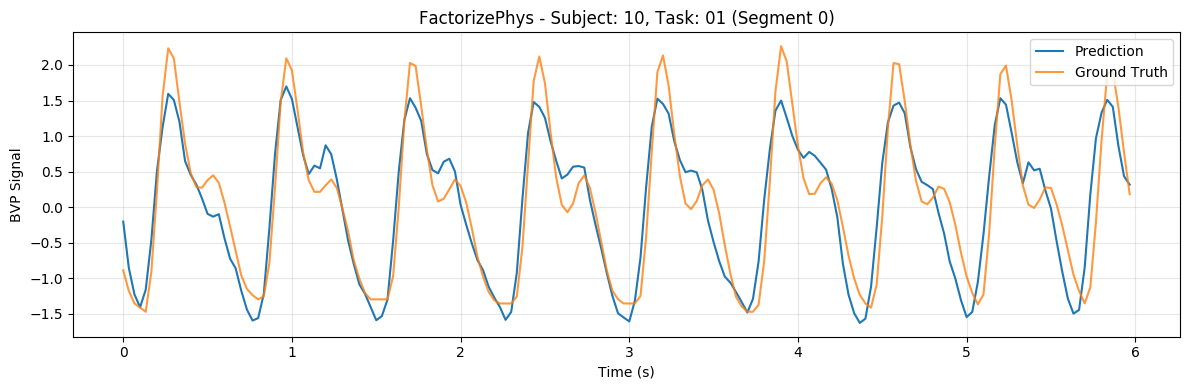

Plotted prediction range: [-1.629, 1.698]
Plotted label range: [-1.472, 2.265]


In [12]:
try:
    if not trial_list:
        raise ValueError("No trials to visualize!")
    
    # Get the selected trial key
    selected_trial = trial_list[trial_idx]
    print(f"Selected trial: {selected_trial}, type: {type(selected_trial)}")
    
    # Debug: Print data structure for debugging
    pred_data = data['predictions'][selected_trial]
    label_data = data['labels'][selected_trial] if 'labels' in data else None
    print(f"Prediction data structure: {type(pred_data)}")
    if isinstance(pred_data, dict):
        print(f"Prediction keys: {list(pred_data.keys())[:5]}...")  # Show first 5 keys
        sample_pred_val = next(iter(pred_data.values()))
        print(f"Sample prediction value type: {type(sample_pred_val)}, shape: {getattr(sample_pred_val, 'shape', 'N/A')}")
    
    if label_data is not None:
        print(f"Label data structure: {type(label_data)}")
        if isinstance(label_data, dict):
            print(f"Label keys: {list(label_data.keys())[:5]}...")  # Show first 5 keys
            sample_label_val = next(iter(label_data.values()))
            print(f"Sample label value type: {type(sample_label_val)}, shape: {getattr(sample_label_val, 'shape', 'N/A')}")
    
    # Reform label and prediction vectors from multiple trial chunks
    try:
        prediction = np.array(_reform_data_from_dict(data['predictions'][selected_trial]))
        print(f"Reformed prediction shape: {prediction.shape}, range: [{np.min(prediction):.3f}, {np.max(prediction):.3f}]")
    except Exception as e:
        print(f"Error reforming prediction data: {e}")
        # Fallback: try to extract data differently
        pred_data = data['predictions'][selected_trial]
        if isinstance(pred_data, dict):
            # Try concatenating values directly
            values = list(pred_data.values())
            if len(values) > 0:
                if isinstance(values[0], (torch.Tensor, np.ndarray)):
                    if isinstance(values[0], torch.Tensor):
                        prediction = torch.cat(values, dim=0).cpu().numpy().flatten()
                    else:
                        prediction = np.concatenate([v.flatten() for v in values])
                else:
                    prediction = np.array(values).flatten()
                print(f"Fallback prediction shape: {prediction.shape}, range: [{np.min(prediction):.3f}, {np.max(prediction):.3f}]")
            else:
                raise ValueError("No prediction data found")
        else:
            raise ValueError("Unexpected prediction data format")
    
    try:
        label = np.array(_reform_data_from_dict(data['labels'][selected_trial])) if 'labels' in data else None
        if label is not None:
            print(f"Reformed label shape: {label.shape}, range: [{np.min(label):.3f}, {np.max(label):.3f}]")
    except Exception as e:
        print(f"Error reforming label data: {e}")
        label = None
        if 'labels' in data:
            # Fallback for labels
            label_data = data['labels'][selected_trial]
            if isinstance(label_data, dict):
                values = list(label_data.values())
                if len(values) > 0:
                    if isinstance(values[0], (torch.Tensor, np.ndarray)):
                        if isinstance(values[0], torch.Tensor):
                            label = torch.cat(values, dim=0).cpu().numpy().flatten()
                        else:
                            label = np.concatenate([v.flatten() for v in values])
                    else:
                        label = np.array(values).flatten()
                    print(f"Fallback label shape: {label.shape}, range: [{np.min(label):.3f}, {np.max(label):.3f}]")
    
    # Read in meta-data from pickle file (with safe defaults)
    raw_fs = data.get('fs', None)
    if raw_fs is None or raw_fs <= 0:
        print(f"Invalid sampling rate ({raw_fs}); defaulting to 30 Hz.")
        fs = 30
    else:
        fs = raw_fs
    
    lt = data.get('label_type', None)
    if not lt:
        print("No label_type found; defaulting to 'Raw'.")
        label_type = 'Raw'
    else:
        label_type = lt
    diff_flag = (label_type == 'DiffNormalized')
    print(f"Label type: {label_type}, Using cumsum: {diff_flag}, Sampling rate: {fs}Hz")
    
    # Extract method name from file path for better plot titles
    method_name = "Unknown"
    is_unsupervised = False
    if "data_out_path" in locals():
        # Unsupervised methods
        if "POS_" in data_out_path:
            method_name = "POS"
            is_unsupervised = True
        elif "CHROM_" in data_out_path:
            method_name = "CHROM"
            is_unsupervised = True
        elif "ICA_" in data_out_path:
            method_name = "ICA"
            is_unsupervised = True
        elif "GREEN_" in data_out_path:
            method_name = "GREEN"
            is_unsupervised = True
        elif "LGI_" in data_out_path:
            method_name = "LGI"
            is_unsupervised = True
        elif "PBV_" in data_out_path:
            method_name = "PBV"
            is_unsupervised = True
        elif "OMIT_" in data_out_path:
            method_name = "OMIT"
            is_unsupervised = True
        # Supervised/neural methods
        elif "FactorizePhys" in data_out_path:
            method_name = "FactorizePhys"
        elif "PhysNet" in data_out_path:
            method_name = "PhysNet"
        elif "DeepPhys" in data_out_path:
            method_name = "DeepPhys"
        elif "EfficientPhys" in data_out_path:
            method_name = "EfficientPhys"
        elif "TSCAN" in data_out_path:
            method_name = "TSCAN"
        elif "RhythmFormer" in data_out_path:
            method_name = "RhythmFormer"
        elif "MetaPhys" in data_out_path:
            method_name = "MetaPhys"
        elif "ViTPhys" in data_out_path:
            method_name = "ViTPhys"
        elif "STVENet" in data_out_path:
            method_name = "STVENet"
        elif "TSCANPlus" in data_out_path:
            method_name = "TSCANPlus"
        elif "WaveletPhys" in data_out_path:
            method_name = "WaveletPhys"
        elif "MambaPhys" in data_out_path:
            method_name = "MambaPhys"
        elif "PhysFormer" in data_out_path:
            method_name = "PhysFormer"
        elif "MTTS_CAN" in data_out_path:
            method_name = "MTTS_CAN"
        elif "CVDPhys" in data_out_path:
            method_name = "CVDPhys"
        elif "TransPhys" in data_out_path:
            method_name = "TransPhys"
        elif "PPGNet" in data_out_path:
            method_name = "PPGNet"
        elif "STMapNet" in data_out_path:
            method_name = "STMapNet"
        elif "HRNet" in data_out_path:
            method_name = "HRNet"
        elif "ResPhys" in data_out_path:
            method_name = "ResPhys"
        elif "MetaPhysFormer" in data_out_path:
            method_name = "MetaPhysFormer"
        elif "EfficientPPG" in data_out_path:
            method_name = "EfficientPPG"
        elif "PhysNetPlus" in data_out_path:
            method_name = "PhysNetPlus"
        elif "PhysNetV2" in data_out_path:
            method_name = "PhysNetV2"
        elif "PhysNetV3" in data_out_path:
            method_name = "PhysNetV3"
        elif "PhysNetV4" in data_out_path:
            method_name = "PhysNetV4"
        elif "PhysNetV5" in data_out_path:
            method_name = "PhysNetV5"
        elif "PhysNetV6" in data_out_path:
            method_name = "PhysNetV6"
        # Add more methods here as needed for your codebase
    
    # Parse subject and task from trial key for PURE dataset format
    subject_info = str(selected_trial)
    task_info = "N/A"
    
    # Convert to string for uniform handling
    trial_str = str(selected_trial)
    print(f"Trial string for parsing: '{trial_str}'")
    
    # Handle PURE dataset format (e.g., "10-01", "01-06")
    if re.match(r'^\d{2}-\d{2}$', trial_str):
        # PURE format: "XX-YY" where XX is subject, YY is task
        parts = trial_str.split('-')
        if len(parts) == 2:
            subject_num = int(parts[0])  # Remove leading zeros
            task_num = int(parts[1])     # Remove leading zeros
            subject_info = f"{subject_num:02d}"  # Format as 2-digit with leading zero if needed
            task_info = f"{task_num:02d}"        # Format as 2-digit with leading zero if needed
    elif trial_str.isdigit():
        # Handle numeric trial keys like "1001", "1002", etc. - convert to PURE format
        if len(trial_str) == 4:
            # Assume format like 1001 -> 10-01, 1002 -> 10-02, etc.
            subject_part = trial_str[:2]
            task_part = trial_str[2:]
            subject_info = f"{int(subject_part):02d}"  # Remove leading zeros, then format
            task_info = f"{int(task_part):02d}"        # Remove leading zeros, then format
        elif len(trial_str) == 3:
            # Assume format like 101 -> 01-01, 102 -> 01-02, etc.
            subject_part = trial_str[0]
            task_part = trial_str[1:]
            subject_info = f"{int(subject_part):02d}"  # Remove leading zeros, then format
            task_info = f"{int(task_part):02d}"        # Remove leading zeros, then format
        else:
            # Fallback: use the number as subject
            subject_info = f"{int(trial_str):02d}"
    else:
        # Try to extract subject and task from filename-style keys
        if "_task" in trial_str:
            parts = trial_str.split("_")
            subject_info = parts[0] if parts else str(selected_trial)
            task_parts = [p for p in parts if "task" in p.lower()]
            if task_parts:
                task_info = task_parts[0]
    
    print(f"Parsed subject: {subject_info}, task: {task_info}")
    
    # Determine chunk to plot
    start_idx = chunk_num * chunk_size if chunk_size > 0 else 0
    end_idx = start_idx + chunk_size if chunk_size > 0 else len(prediction)
    pred_segment = prediction[start_idx:end_idx]
    label_segment = label[start_idx:end_idx] if label is not None else None
    
    # For unsupervised methods: Check if we need to process raw BVP signal differently
    if is_unsupervised and pred_segment is not None:
        pred_range = np.max(pred_segment) - np.min(pred_segment)
        label_range = np.max(label_segment) - np.min(label_segment) if label_segment is not None else 0
        print(f"Prediction is unsupervised method output - range: {pred_range:.3f}")
        print(f"Label range: {label_range:.3f}")
        
        # Check if prediction looks like raw BVP (small range) vs HR (large range like 40-200 BPM)
        if pred_range < 10 and label_range > 10:
            print("Detected raw BVP prediction vs HR label - processing prediction signal...")
            
            # Process the prediction signal to extract a meaningful representation
            try:
                # Apply the same processing as used in the evaluation
                processed_pred = _process_signal(pred_segment, fs=fs, diff_flag=diff_flag)
                
                # Option 1: Scale to similar range as ground truth for better visualization
                if len(processed_pred) > 0 and np.std(processed_pred) > 0:
                    # Normalize and scale to match label range approximately
                    processed_pred = (processed_pred - np.mean(processed_pred)) / np.std(processed_pred)
                    if label_segment is not None:
                        target_mean = np.mean(label_segment)
                        target_std = np.std(label_segment)
                        processed_pred = processed_pred * target_std + target_mean
                    
                    pred_segment = processed_pred
                    print(f"Processed prediction range: [{np.min(pred_segment):.3f}, {np.max(pred_segment):.3f}]")
                else:
                    print("Warning: Could not process prediction signal effectively")
                    
            except Exception as e:
                print(f"Error processing prediction signal: {e}")
                # Fallback: just scale the raw signal
                if label_segment is not None and np.std(pred_segment) > 0:
                    pred_segment = (pred_segment - np.mean(pred_segment)) / np.std(pred_segment)
                    pred_segment = pred_segment * np.std(label_segment) + np.mean(label_segment)
    
    # Plot
    plt.figure(figsize=(12, 4))
    times = np.arange(len(pred_segment)) / fs
    plt.plot(times, pred_segment, label='Prediction', linewidth=1.5)
    if label_segment is not None:
        plt.plot(times, label_segment, label='Ground Truth', linewidth=1.5, alpha=0.8)
    plt.xlabel('Time (s)')
    
    # Adjust y-label based on whether we processed the signal
    if is_unsupervised and pred_range < 10:
        plt.ylabel('Processed Signal (scaled)')
    else:
        plt.ylabel('BVP Signal')
        
    plt.title(f'{method_name} - Subject: {subject_info}, Task: {task_info} (Segment {chunk_num})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print some debug info
    print(f"Plotted prediction range: [{np.min(pred_segment):.3f}, {np.max(pred_segment):.3f}]")
    if label_segment is not None:
        print(f"Plotted label range: [{np.min(label_segment):.3f}, {np.max(label_segment):.3f}]")
    
except Exception as e:
    print(f"Error during visualization: {e}")
    import traceback
    traceback.print_exc()
    plt.figure(figsize=(10,3))
    plt.text(0.5, 0.5, f"Error: {str(e)}", 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.axis('off')
    plt.show()